In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'

In [2]:
def maybe_download(filename, expected_bytes):
	"""Download a file if not present, and make sure it's the right size."""
	local_filename = os.path.join(os.getcwd(), filename)
	if not os.path.exists(local_filename):
		local_filename, _ = urllib.request.urlretrieve(url + filename,local_filename)
	#statinfo = os.stat(local_filename)
	#if statinfo.st_size == expected_bytes:
	#	print('Found and verified', filename)
	#else:
	#	print(statinfo.st_size)
	#	raise Exception('Failed to verify ' + local_filename +
	#									'. Can you get to it with a browser?')
	return local_filename

In [3]:
filename = maybe_download('paths.zip',4058291)

In [4]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

In [5]:
vocabulary = read_data(filename)
print('Data size', len(vocabulary))

# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 100000

Data size 925915


In [6]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    #count = [[]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    #print(count)
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        #print(word,index)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [7]:
# Filling 4 global variables:
# data - list of codes (integers from 0 to vocabulary_size-1).
#   This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# dictionary - map of words(strings) to their codes(integers)
# reverse_dictionary - maps codes(integers) to words(strings)
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,vocabulary_size)
#del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 0], ('6939', 107760), ('9002', 28904), ('6830', 21032), ('7545', 14248)]
Sample data [1, 21, 1784, 6245, 1, 21, 1784, 6245, 1, 21] ['6939', '4826', '38803', '56203', '6939', '4826', '38803', '56203', '6939', '4826']


In [9]:
len(vocabulary)

925915

In [10]:
data_index = 0

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [11]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
                '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

21 4826 -> 1 6939
21 4826 -> 1784 38803
1784 38803 -> 21 4826
1784 38803 -> 6245 56203
6245 56203 -> 1 6939
6245 56203 -> 1784 38803
1 6939 -> 6245 56203
1 6939 -> 21 4826


In [12]:
# Step 4: Build and train a skip-gram model.

batch_size = 256
embedding_size = 512  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
num_sampled = 64      # Number of negative examples to sample.

In [13]:
# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. These 3 variables are used only for
# displaying model accuracy, they don't affect calculation.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [14]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/gpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                                                        stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,
                                         biases=nce_biases,
                                         labels=train_labels,
                                         inputs=embed,
                                         num_sampled=num_sampled,
                                         num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    #optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # What if we use AdamOptimizer
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),
     1, keepdims=True)) #keep_dims is deprecated use keepdims instead
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
            normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
            valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

In [17]:
# Step 5: Begin training.
num_steps = 7000

In [18]:
with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
                batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 200 == 0:
            if step > 0:
                average_loss /= 200
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        #if step % 10000 == 0: #500 == 0:#
        #	sim = similarity.eval()
        #	for i in xrange(valid_size):
        #		valid_word = reverse_dictionary[valid_examples[i]]
        #		top_k = 4#8  # number of nearest neighbors
        #		nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        #		log_str = 'Nearest to %s:' % valid_word
        #		for k in xrange(top_k):
        #			close_word = reverse_dictionary[nearest[k]]
        #			log_str = '%s %s,' % (log_str, close_word)
        #		print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  322.18914794921875
Average loss at step  200 :  308.195693283081
Average loss at step  400 :  305.05934265136716
Average loss at step  600 :  304.1158033752441
Average loss at step  800 :  301.4589684295654
Average loss at step  1000 :  295.75373695373537
Average loss at step  1200 :  293.7986316680908
Average loss at step  1400 :  298.8480999755859
Average loss at step  1600 :  297.640160446167
Average loss at step  1800 :  298.97464881896974
Average loss at step  2000 :  296.6105741882324
Average loss at step  2200 :  296.18608596801755
Average loss at step  2400 :  292.9658441925049
Average loss at step  2600 :  286.79937301635744
Average loss at step  2800 :  285.9495681762695
Average loss at step  3000 :  283.69628273010255
Average loss at step  3200 :  280.5534354400635
Average loss at step  3400 :  285.7179998779297
Average loss at step  3600 :  281.5016855621338
Average loss at step  3800 :  276.37231903076173
Average loss at step  4000 : 

In [19]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(20,20))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                                 xy=(x, y),
                                 xytext=(5, 2),
                                 textcoords='offset points',
                                 ha='right',
                                 va='bottom')

    plt.show()
    #plt.savefig(filename)try:
    # pylint: disable=g-import-not-at-top


final_embeddings size (100000, 512)


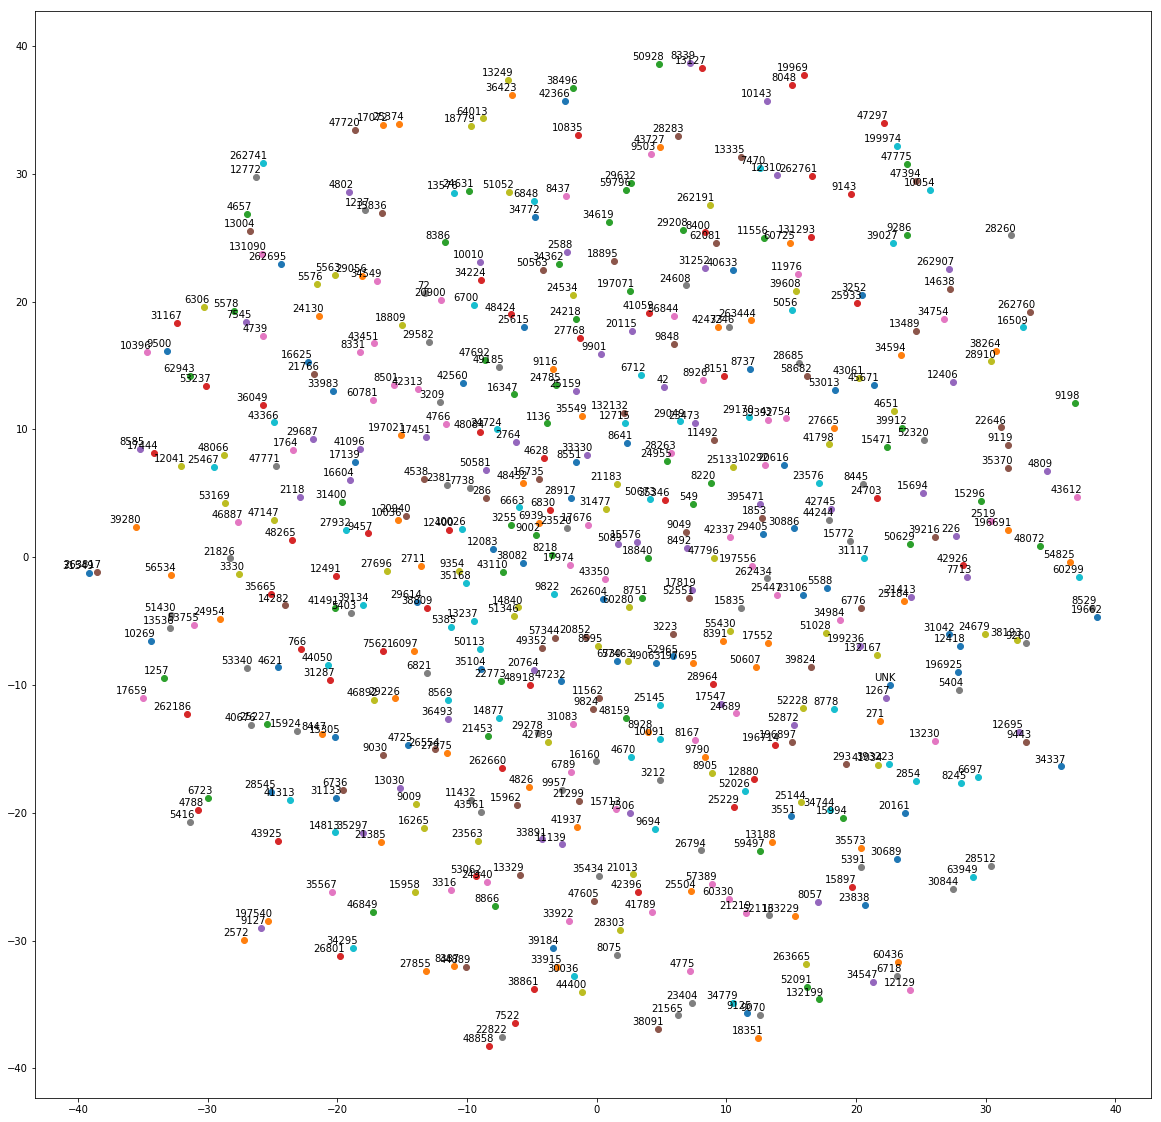

In [21]:
try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    %matplotlib inline
    print("final_embeddings size",final_embeddings.shape)
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join(os.getcwd(), str(filename+"_"+str(num_steps)+".png")))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)